# Detectiemodel met TFLite

In [ ]:
# from ultralytics import YOLO #NIET GEBRUIKEN
import matplotlib.pyplot as plt
from skimage.filters import threshold_sauvola
from skimage.morphology import reconstruction, remove_small_objects, binary_opening, disk, binary_erosion
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
import networkx as nx
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import skeletonize, binary_dilation
from skimage.transform import resize
from torch_geometric.utils import dense_to_sparse
import networkx as nx
from torch_geometric.utils import remove_self_loops
import warnings
import torch
from torch_geometric.nn import VGAE
import torch.nn.functional as F
from torch_geometric.nn import GINConv, JumpingKnowledge
import tensorflow as tf

In [ ]:
model_path = r"C:\Users\lenka\OneDrive\Documenten\Afstuderen Master\pipeline\detectie_model.tflite"
image_path = r"C:\Users\lenka\OneDrive\Documenten\Afstuderen Master\eigen data\krassen\new_image4.jpg"

# Detectie model met TFLite

[DEBUG] Originele afbeelding: breedte=3280, hoogte=2464


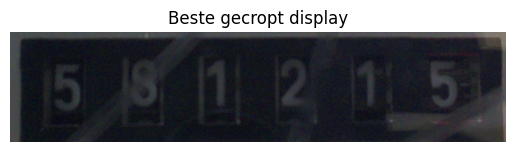

Geen rotatie nodig.


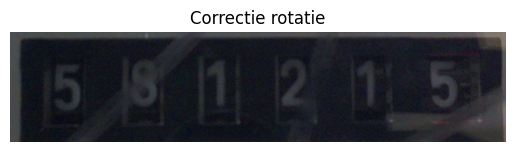

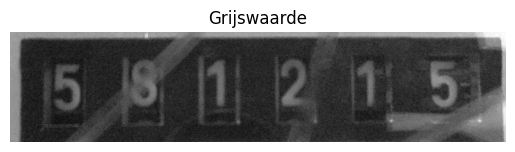

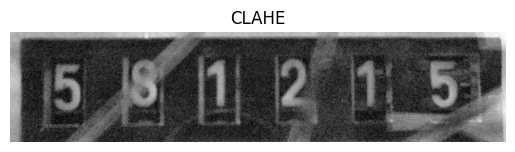

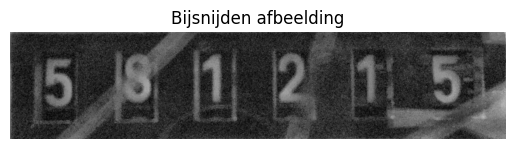

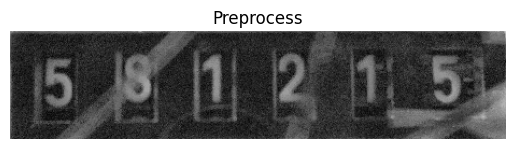

In [19]:
# === LAAD MODEL ===
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
input_height, input_width = input_shape[1], input_shape[2]

# === LAAD EN VERWERK AFBEELDING ===
original_img = cv2.imread(image_path)
orig_h, orig_w = original_img.shape[:2]
print(f"[DEBUG] Originele afbeelding: breedte={orig_w}, hoogte={orig_h}")

image_resized = cv2.resize(original_img, (input_width, input_height))
input_tensor = np.expand_dims(image_resized.astype(np.float32) / 255.0, axis=0)

interpreter.set_tensor(input_details[0]['index'], input_tensor)
interpreter.invoke()

# === VERWERK OUTPUT ===
output = interpreter.get_tensor(output_details[0]['index'])  # [1, 5, 525]
output = np.squeeze(output).T  # [525, 5]

detections = []
threshold = 0.2

for row in output:
    xc, yc, w, h, conf = row
    if conf >= threshold:
        x1 = int((xc - w / 2) * orig_w)
        y1 = int((yc - h / 2) * orig_h)
        x2 = int((xc + w / 2) * orig_w)
        y2 = int((yc + h / 2) * orig_h)

        x1, x2 = max(0, x1), min(orig_w, x2)
        y1, y2 = max(0, y1), min(orig_h, y2)
        detections.append((conf, (x1, y1, x2, y2)))

# === SELECTEER BESTE DETECTIE ===
if detections:
    detections.sort(reverse=True, key=lambda x: x[0])
    _, (x1, y1, x2, y2) = detections[0]
    cropped_display = original_img[y1:y2, x1:x2]

    plt.imshow(cv2.cvtColor(cropped_display, cv2.COLOR_BGR2RGB))
    plt.title("Beste gecropt display")
    plt.axis("off")
    plt.show()
else:
    print("Geen objecten gedetecteerd.")
    cropped_display = original_img.copy()

# === ROTATIECORRECTIE ===
edges = cv2.Canny(cropped_display, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)

angles = []
if lines is not None:
    for rho, theta in lines[:, 0]:
        deg = np.degrees(theta)
        if abs(deg - 90) < 15:
            angles.append(deg - 90)

if angles:
    median_angle = round(np.median(angles) * 2) / 2.0
    print(f"[DEBUG] Rotatiehoek op crop: {median_angle:.2f}°")
    (h, w) = cropped_display.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    rotated_display = cv2.warpAffine(cropped_display, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
else:
    print("Geen rotatie nodig.")
    rotated_display = cropped_display.copy()

plt.imshow(cv2.cvtColor(rotated_display, cv2.COLOR_BGR2RGB))
plt.title("Correctie rotatie")
plt.axis("off")
plt.show()

# === GRIJSMAKEN + CLAHE ===
gray_display = cv2.cvtColor(rotated_display, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_display, cmap='gray')
plt.title("Grijswaarde")
plt.axis("off")
plt.show()

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray_display)
plt.imshow(enhanced, cmap='gray')
plt.title("CLAHE")
plt.axis("off")
plt.show()

# === SMART TRIM FUNCTIE ===
def smart_trim(image, threshold=100, max_trim=60, white_ratio=0.80, lookahead=30):
    if len(image.shape) == 2:
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    h, w = gray.shape
    top, bottom, left, right = 0, h, 0, w

    for y in range(max_trim):
        row = gray[y, :]
        ratio = np.sum(row > threshold) / w
        if ratio < white_ratio:
            lookahead_rows = gray[y+1:y+1+lookahead, :]
            lookahead_ratios = np.mean(np.sum(lookahead_rows > threshold, axis=1) / w)
            if lookahead_ratios < white_ratio:
                break
        top += 1

    for y in range(h - 1, h - max_trim - 1, -1):
        row = gray[y, :]
        ratio = np.sum(row > threshold) / w
        if ratio < white_ratio:
            lookahead_rows = gray[max(0, y-lookahead):y, :]
            lookahead_ratios = np.mean(np.sum(lookahead_rows > threshold, axis=1) / w)
            if lookahead_ratios < white_ratio:
                break
        bottom -= 1

    for x in range(max_trim):
        col = gray[:, x]
        ratio = np.sum(col > threshold) / h
        if ratio < white_ratio:
            lookahead_cols = gray[:, x+1:x+1+lookahead]
            lookahead_ratios = np.mean(np.sum(lookahead_cols > threshold, axis=0) / h)
            if lookahead_ratios < white_ratio:
                break
        left += 1

    for x in range(w - 1, w - max_trim - 1, -1):
        col = gray[:, x]
        ratio = np.sum(col > threshold) / h
        if ratio < white_ratio:
            lookahead_cols = gray[:, max(0, x-lookahead):x]
            lookahead_ratios = np.mean(np.sum(lookahead_cols > threshold, axis=0) / h)
            if lookahead_ratios < white_ratio:
                break
        right -= 1

    if right > left and bottom > top:
        return image[top:bottom, left:right]
    else:
        print("Ongeldige smart crop — origineel teruggegeven.")
        return image

trimmed = smart_trim(enhanced)

plt.imshow(cv2.cvtColor(trimmed, cv2.COLOR_BGR2RGB))
plt.title("Bijsnijden afbeelding")
plt.axis("off")
plt.show()

# === NORMALISATIE NAAR VASTE HOOGTE ===
def normalize_height(image, target_height=100):
    h, w = image.shape[:2]
    scale = target_height / h
    new_w = int(w * scale)
    return cv2.resize(image, (new_w, target_height), interpolation=cv2.INTER_CUBIC)

normalized = normalize_height(trimmed)

plt.imshow(cv2.cvtColor(normalized, cv2.COLOR_BGR2RGB))
plt.title("Preprocess")
plt.axis("off")
plt.show()
